In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('historical_weather.csv')
print(df.head(1))
print(df.count())

  city_id        date  avg_temp_c  min_temp_c  max_temp_c  precipitation_mm  \
0    C001  2014-01-01         6.6        -1.4        11.6               NaN   

   snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  
0            NaN             168.0                 6.2  
city_id               182338
date                  182338
avg_temp_c            181114
min_temp_c            176452
max_temp_c            174845
precipitation_mm      112594
snow_depth_mm          12238
avg_wind_dir_deg      146944
avg_wind_speed_kmh    159866
dtype: int64


In [4]:
unique_city_count = df['city_id'].nunique()
print(unique_city_count)

100


In [5]:
def plot_correlation(correlation, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(correlation, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(np.arange(len(correlation.columns)),
               correlation.columns, rotation=90)
    plt.yticks(np.arange(len(correlation.columns)), correlation.columns)
    plt.show()

In [6]:
correlation = df[['avg_temp_c', 'min_temp_c', 'max_temp_c',
                  'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh']].corr()
# print(correlation.head(1))

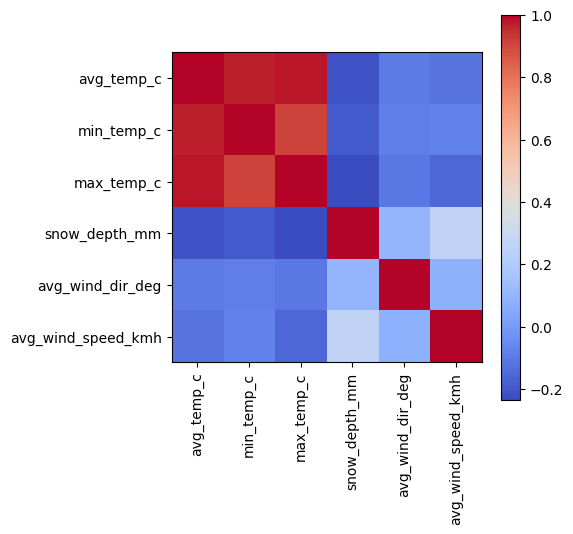

In [7]:
# Assuming that 'correlation' is your correlation matrix
plot_correlation(correlation)

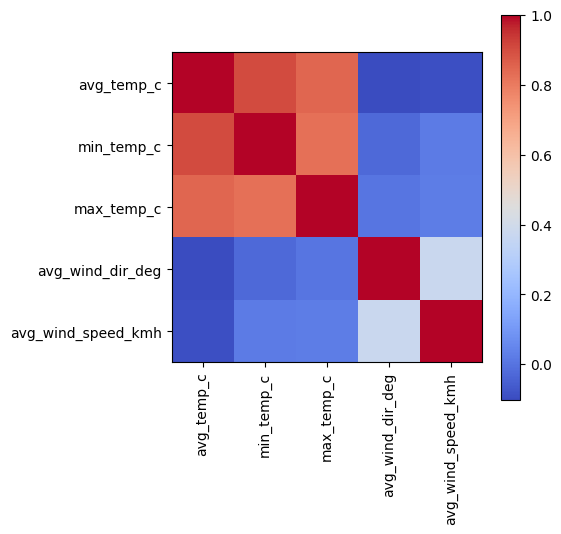

In [8]:
correlation = df[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'avg_wind_dir_deg', 'avg_wind_speed_kmh']].fillna(-1).corr()
plot_correlation(correlation)

In [9]:
data = df

In [10]:
# Calculate the IQR
Q1 = data['avg_temp_c'].quantile(0.25)
Q3 = data['avg_temp_c'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['avg_temp_c'] < lower_bound) | (data['avg_temp_c'] > upper_bound)]
print("Outliers in avg_temp_c:")
print(outliers)
outliers.shape, data.shape
# Remove outliers
data_cleaned = data[(data['avg_temp_c'] >= lower_bound) & (data['avg_temp_c'] <= upper_bound)]

# Display the cleaned data
print(data_cleaned.head())
data  = data_cleaned 

Outliers in avg_temp_c:
       city_id        date  avg_temp_c  min_temp_c  max_temp_c  \
5500      C004  2014-02-18        -9.7       -13.4        -5.9   
5813      C004  2014-12-28       -10.5       -12.6        -8.3   
5819      C004  2015-01-03       -11.7       -15.7        -7.6   
5820      C004  2015-01-04       -10.6       -16.8        -4.4   
5850      C004  2015-02-03        -9.8       -12.8        -6.8   
...        ...         ...         ...         ...         ...   
168907    C105  2017-02-16       -10.0       -20.6        -4.8   
168910    C105  2017-02-19        -9.9       -15.2        -1.0   
169219    C105  2017-12-26       -11.3       -15.0        -3.2   
169248    C105  2018-01-24       -10.6       -17.2        -4.3   
175095    C109  2014-01-28       -10.2       -13.0        -5.2   

        precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  
5500                 0.0           90.0               NaN                17.3  
5813                 0.

In [11]:
df = data

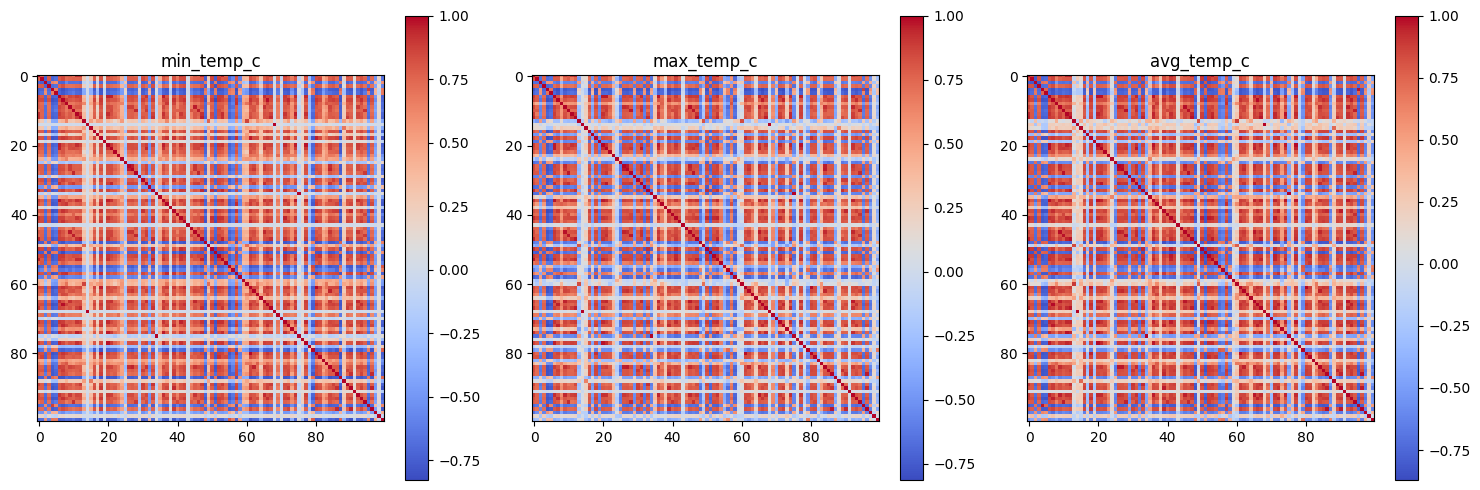

In [12]:
def sub_plot_correlation(correlation, subplot_position, title):
    plt.subplot(1, 3, subplot_position)
    plt.imshow(correlation, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.title(title)


plt.figure(figsize=(15, 5))

temp_types = ['min_temp_c', 'max_temp_c', 'avg_temp_c']
for i, temp_type in enumerate(temp_types, 1):
    df_pivot = df.pivot(index='date', columns='city_id', values=temp_type)
    correlation = df_pivot.corr()
    sub_plot_correlation(correlation, i, temp_type)

plt.tight_layout()
plt.show()

In [13]:
df['date'] = pd.to_datetime(
    df['date'], format='%Y-%m-%d')

In [14]:
# Generate features for each city
def create_features(df):
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df['city'] = df['city_id'].str.extract(r'(\d+)').astype(int)    
    
    for lag in [1, 3, 7]:
        df[f'avg_temp_lag_{lag}'] = df['avg_temp_c'].shift(lag)
        df[f'min_temp_lag_{lag}'] = df['min_temp_c'].shift(lag)
        df[f'max_temp_lag_{lag}'] = df['max_temp_c'].shift(lag)
        df[f'precipitation_lag_{lag}'] = df['precipitation_mm'].shift(lag)
        df[f'snow_depth_lag_{lag}'] = df['snow_depth_mm'].shift(lag)
        df[f'wind_dir_deg_lag_{lag}'] = df['avg_wind_dir_deg'].shift(lag)
        df[f'wind_speed_lag_{lag}'] = df['avg_wind_speed_kmh'].shift(lag)

    for window in [7]:
        df[f'avg_temp_rolling_mean_{window}'] = df['avg_temp_c'].rolling(
            window=window).mean()
        df[f'max_temp_rolling_max_{window}'] = df['max_temp_c'].rolling(
            window=window).max()
        df[f'min_temp_rolling_min_{window}'] = df['min_temp_c'].rolling(
            window=window).min()
        df[f'precipitation_rolling_sum_{window}'] = df['precipitation_mm'].rolling(
            window=window).sum()
        df[f'snow_depth_rolling_mean_{window}'] = df['snow_depth_mm'].rolling(
            window=window).mean()
        df[f'wind_speed_rolling_mean_{window}'] = df['avg_wind_speed_kmh'].rolling(
            window=window).mean()
        df[f'wind_dir_rolling_mean_{window}'] = df['avg_wind_dir_deg'].rolling(
            window=window).mean()

    df['temp_range'] = df['max_temp_c'] - df['min_temp_c']

    return df


# Apply feature creation to each city
data = df.groupby('city_id').apply(create_features).reset_index(drop=True)
data.to_csv('new_features_added.csv', index=False)

In [15]:
# Generate features for each city
def create_features_min(df):
    df['city'] = df['city_id'].str.extract(r'(\d+)').astype(int)
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month

    df['temp_range'] = df['max_temp_c'] - df['min_temp_c']

    return df

# Apply feature creation to each city
data2 = df.groupby('city_id').apply(create_features_min).reset_index(drop=True)
data2.to_csv('new_features_added_min.csv', index=False)

In [16]:
# Create a copy of the original DataFrame
df_copy = df.copy()
# Group the copied DataFrame by 'city_id'
city_df_copy = df_copy.groupby('city_id')
# Fill missing values in the copy using the same approach as before
df_copy.loc[df_copy['avg_temp_c'].isnull(), 'avg_temp_c'] = city_df_copy['avg_temp_c'].transform(lambda x: x.fillna(x.mean()))
df_copy.loc[df_copy['min_temp_c'].isnull(), 'min_temp_c'] = city_df_copy['min_temp_c'].transform(lambda x: x.fillna(x.mean()))
df_copy.loc[df_copy['max_temp_c'].isnull(), 'max_temp_c'] = city_df_copy['max_temp_c'].transform(lambda x: x.fillna(x.mean()))
df_copy.loc[df_copy['precipitation_mm'].isnull(), 'precipitation_mm'] = city_df_copy['precipitation_mm'].transform(lambda x: x.fillna(x.mean()))
# Uncomment if you decide to fill 'snow_depth_mm' as well
# df_copy.loc[df_copy['snow_depth_mm'].isnull(), 'snow_depth_mm'] = city_df_copy['snow_depth_mm'].transform(lambda x: x.fillna(x.mean()))
df_copy.loc[df_copy['avg_wind_dir_deg'].isnull(), 'avg_wind_dir_deg'] = city_df_copy['avg_wind_dir_deg'].transform(lambda x: x.fillna(x.mean()))
df_copy.loc[df_copy['avg_wind_speed_kmh'].isnull(), 'avg_wind_speed_kmh'] = city_df_copy['avg_wind_speed_kmh'].transform(lambda x: x.fillna(x.mean()))

# Calculate 'temp_range' in the copy
df_copy['temp_range'] = df_copy['max_temp_c'] - df_copy['min_temp_c']

In [17]:
data3 = df.groupby('city_id').apply(create_features_min).reset_index(drop=True)
data3.to_csv('new_features_added_filled_min.csv', index=False)

In [18]:
def fill_with_nearest_avg(series):
    for i in series[series.isnull()].index:
        # Find indices of the non-null values
        non_null_indices = series.dropna().index

        # Find the closest indices on both sides of the current null index
        lower_indices = non_null_indices[non_null_indices < i]
        upper_indices = non_null_indices[non_null_indices > i]

        values_to_avg = []

        if not lower_indices.empty:
            # Take up to 2 closest non-null values from the lower side
            values_to_avg.extend(series[lower_indices[-2:]].tolist())

        if not upper_indices.empty:
            # Take up to 2 closest non-null values from the upper side
            values_to_avg.extend(series[upper_indices[:2]].tolist())

        # Calculate the average if there are any values to average
        if values_to_avg:
            series.at[i] = np.mean(values_to_avg)

    return series

In [19]:
unique_city_count = df['city_id'].nunique()
print(unique_city_count)

100


In [21]:
df_copy = df.copy()

# Apply the custom function to each specified column
for column in ['avg_temp_c', 'min_temp_c', 'max_temp_c']:
    df_copy[column] = fill_with_nearest_avg(df_copy[column])
    print(column)


avg_temp_c
min_temp_c
max_temp_c


In [22]:
for column in ['avg_wind_dir_deg', 'avg_wind_speed_kmh']:
    df_copy[column] = fill_with_nearest_avg(df_copy[column])
    print(column)

avg_wind_dir_deg
avg_wind_speed_kmh


In [26]:
# Drop the precipitation and snow data columns
df_copy_modified = df_copy.drop(['precipitation_mm', 'snow_depth_mm'], axis=1)
df_copy_modified = create_features_min(df_copy_modified)
# Save the modified DataFrame to a CSV file, correcting the 'index' parameter
df_copy_modified.to_csv(
'new_features_added_filled_nearest_neigb_min.csv', index=False)

In [27]:
unique_city_count = df_copy_modified['city_id'].nunique()
print(unique_city_count)

100


In [28]:
# Assuming 'avg_temp_c', 'min_temp_c', and 'max_temp_c' are the temperature-related columns
min_temp = df.groupby('city_id')[
    ['avg_temp_c', 'min_temp_c', 'max_temp_c']].min()
max_temp = df.groupby('city_id')[
    ['avg_temp_c', 'min_temp_c', 'max_temp_c']].max()
avg_temp = df.groupby('city_id')[
    ['avg_temp_c', 'min_temp_c', 'max_temp_c']].mean()

# Combine the DataFrames into a single DataFrame
temp_stats = pd.concat([min_temp, max_temp, avg_temp],
                       axis=1, keys=['min', 'max', 'avg'])

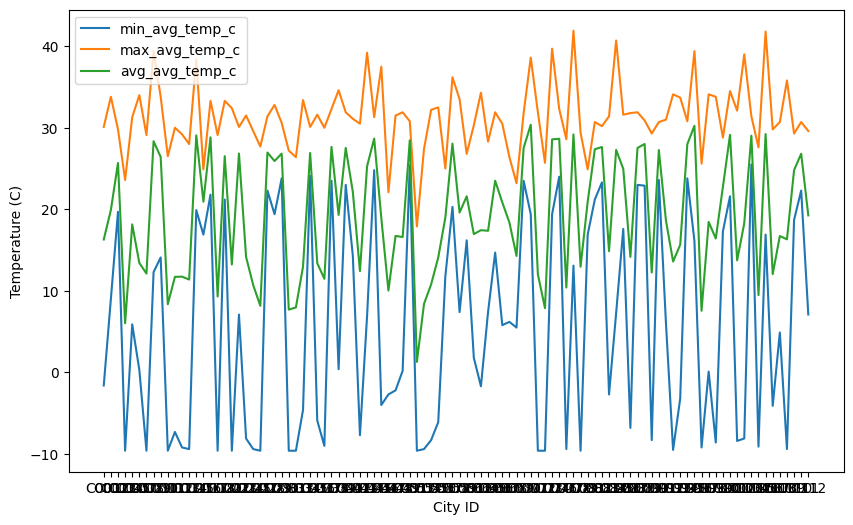

In [29]:
# Reshape the DataFrame
temp_stats.columns = ['_'.join(col) for col in temp_stats.columns.values]
temp_stats.reset_index(inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))

for column in ['min_avg_temp_c', 'max_avg_temp_c', 'avg_avg_temp_c']:
    plt.plot(temp_stats['city_id'], temp_stats[column], label=column)

plt.xlabel('City ID')
plt.ylabel('Temperature (C)')
plt.legend()

plt.show()